In [1]:
pip install transformers

     |████████████████████████████████| 2.1MB 14.7MB/s 
     |████████████████████████████████| 3.2MB 38.2MB/s 
     |████████████████████████████████| 890kB 53.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=8abf928a40351e6963f5e0f1dae5708db6ac81cd02db229191c78751d1c7d1ea
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Importing Transformers pipeline

In [2]:
import pandas as pd

from transformers import pipeline

# Loading Date

In [3]:
train_df =  pd.read_csv('/content/drive/MyDrive/data/train 2.csv',names=['Description','Commenting','Staring','Touching'],skiprows=1)
test_df=pd.read_csv('/content/drive/MyDrive/data/test 2.csv',names=['Description','Commenting','Staring','Touching'],skiprows=1)

dev_df=pd.read_csv('/content/drive/MyDrive/data/dev.csv',names=['Description','Commenting','Staring','Touching'],skiprows=1)

In [ ]:
train_df

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0
...,...,...,...,...
7196,There was this person near a construction site...,0,1,0
7197,He threatened me by making inappropriate conve...,1,0,0
7198,happened during morning at university metro st...,1,0,0
7199,one day my aunt was returniec frm office .. sh...,0,0,0


In [ ]:
train_df['Description'][0]

'Was walking along crowded street, holding mums hand, when an elderly man groped butt, I turned to look at h7m and he looked away, and did it again after a while.I was 12 yrs old then.'

# Code to tokenize and extract features from bert  ,
##  output we need is only from [CLS] , which exracts the whole sentence and base bert output will be *768dim vec* which we are converting into np.array for ease of operation

In [141]:
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf


import numpy as np
tokeniz = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
modelb = TFDistilBertModel.from_pretrained('distilbert-base-uncased',config = bertconfig)
bertconfig = DistilBertConfig.from_pretrained('distilbert-base-uncased', output_hidden_states=True)



def convertion(string):
    inputs = tokeniz(string, return_tensors="tf")
    outputs = modelb(inputs)
    outputs = np.concatenate((outputs[1][6][0,0,:],outputs[1][5][0,0,:],outputs[1][4][0,0,:],outputs[1][3][0,0,:]),axis=0)

    return np.array(outputs)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [58]:
type(outputs)


transformers.modeling_tf_outputs.TFBaseModelOutput

In [74]:
inputs = convertion("Hello, my dog is cute")



In [76]:
inputs.shape

(3072,)

# Loop to iterate in data and saving output vector corresponding to sentence in train_vec

In [77]:
from tqdm import tqdm
sent =[]
train_vec=[]
for i in tqdm((train_df['Description'].values)):
    text = i[:512]
    train_vec.append(convertion(text))


100%|██████████| 7201/7201 [07:22<00:00, 16.28it/s]


In [78]:
train_vec=np.array(train_vec)

train_vec.shape

(7201, 3072)

## Same for DEV data

In [79]:
from tqdm import tqdm

test_vec=[]
for i in tqdm(dev_df['Description']):
    text = i[:512]
    test_vec.append(convertion(text))

100%|██████████| 990/990 [01:01<00:00, 16.07it/s]


In [80]:
test_vec=np.array(test_vec)

test_vec.shape

(990, 3072)

# Preparing data for evaluation of model

In [81]:
eval_vec=[]
for i in tqdm(test_df['Description']):
    text = i[:512]
    eval_vec.append(convertion(text))

100%|██████████| 1701/1701 [01:44<00:00, 16.34it/s]


In [82]:
eval_vec=np.array(eval_vec)

eval_vec.shape

(1701, 3072)

# Logestic Regression 

In [83]:
from sklearn.linear_model import LogisticRegression


In [84]:

y_train=train_df['Commenting']


y_test=dev_df['Commenting']

y_eval=test_df['Commenting']

In [85]:
y_test.shape

(990,)

In [86]:
features=train_vec

In [87]:
lr_clf = LogisticRegression()
lr_clf.fit(features, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [88]:
y_pred0 = lr_clf.predict(test_vec)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr_clf.score(test_vec,y_test )))

Accuracy of logistic regression classifier on test set: 0.78


In [89]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred0)

0.7838383838383839

AxesSubplot(0.125,0.125;0.62x0.755)


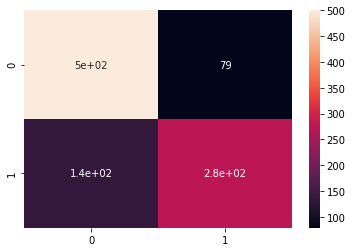

In [90]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
cm=confusion_matrix = confusion_matrix(y_test, y_pred0)

print(heatmap(cm,annot=True))


In [91]:
lr_clf.score(eval_vec,y_eval)

0.7901234567901234

# How Good is this model as compared to that of Random Model

In [92]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

clf = DummyClassifier()

scores = cross_val_score(clf, eval_vec, y_eval)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.538 (+/- 0.06)


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


# **Lets Try SVM for the same task.**





In [93]:
from sklearn import svm


In [94]:
clf = svm.SVC()
clf.fit(features, y_train)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [95]:
y_pred1 = clf.predict(test_vec)
accuracy_score(y_test, y_pred1)

0.7676767676767676

AxesSubplot(0.125,0.125;0.62x0.755)


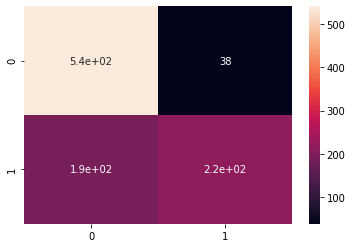

In [96]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix = confusion_matrix(y_test, y_pred1)

print(heatmap(cm,annot=True))

In [97]:
clf.score(eval_vec,y_eval)

0.781305114638448

# XGBOOST

In [98]:
from xgboost import XGBClassifier


In [99]:

# fit model  training data
xgb = XGBClassifier()
xgb.fit(features, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [100]:

# make predictions for test data
y_pred2 = xgb.predict(test_vec)
accuracy_score(y_test, y_pred2)

0.7585858585858586

In [101]:
xgb.score(eval_vec,y_eval
          )

0.7795414462081128

# Much waited --- *DEEP LEARNING*




In [183]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional,LSTM,Flatten,GlobalAveragePooling1D,Embedding
from tensorflow.keras.regularizers import L2
from keras.layers import TimeDistributed


model1 = tf.keras.Sequential([
    Bidirectional(LSTM(512,input_shape=(None,None,3072),return_sequences=True)),
    Bidirectional( LSTM(256,recurrent_dropout=0.6,return_sequences=True,)),
    LSTM(64),

    Flatten(),
    tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer=L2(0.0001),kernel_initializer='glorot_uniform'),

    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=L2(0.0001),kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=L2(0.0001),kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=L2(0.0001),kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=L2(0.001),kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(1, activation='sigmoid',kernel_regularizer=L2(0.0001),kernel_initializer='glorot_uniform')
])

#model1.summary()


In [184]:
model1.compile(optimizer='adam',
              loss= 'binary_crossentropy',
              metrics=['accuracy'])



**Our TrainX and Train is in shape(7201,768) and (1701,768) 
but LSTM accepts 3D tensor SO lets convert....**

In [121]:
#print(train_vec.shape)
train_vec1 = train_vec.reshape(7201 ,1,3072)
print(train_vec1.shape)

test_vec1 = test_vec.reshape(990,1,3072)
print(test_vec1.shape)




(7201, 1, 3072)
(990, 1, 3072)


In [185]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10)
]

In [186]:
history1=model1.fit(train_vec1, y_train, epochs=500,batch_size=32,validation_data=(test_vec1
                                                                                  ,  y_test),steps_per_epoch=100,validation_steps=30
                    ,callbacks=my_callbacks)

Epoch 1/500
100/100 [==============================] - 12s 41ms/step - loss: 0.7691 - accuracy: 0.5629 - val_loss: 0.7009 - val_accuracy: 0.5865
Epoch 2/500
100/100 [==============================] - 2s 24ms/step - loss: 0.6784 - accuracy: 0.6003 - val_loss: 0.6185 - val_accuracy: 0.7115
Epoch 3/500
100/100 [==============================] - 2s 24ms/step - loss: 0.6455 - accuracy: 0.6469 - val_loss: 0.5828 - val_accuracy: 0.7333
Epoch 4/500
100/100 [==============================] - 2s 24ms/step - loss: 0.5977 - accuracy: 0.7262 - val_loss: 0.5689 - val_accuracy: 0.7458
Epoch 5/500
100/100 [==============================] - 2s 24ms/step - loss: 0.5905 - accuracy: 0.7231 - val_loss: 0.5426 - val_accuracy: 0.7552
Epoch 6/500
100/100 [==============================] - 2s 24ms/step - loss: 0.5503 - accuracy: 0.7605 - val_loss: 0.5571 - val_accuracy: 0.7385
Epoch 7/500
100/100 [==============================] - 2s 24ms/step - loss: 0.5643 - accuracy: 0.7331 - val_loss: 0.5308 - val_accuracy

In [187]:
eval_vec=eval_vec.reshape(1701,1,3072)
model1.evaluate(eval_vec,y_eval)



54/54 [==============================] - 0s 6ms/step - loss: 0.4790 - accuracy: 0.7872


[0.47903501987457275, 0.7871840000152588]

In [110]:

import matplotlib.pyplot  as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


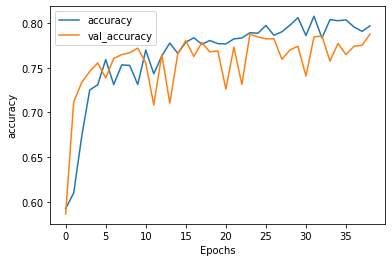

In [188]:
plot_graphs(history1, "accuracy")


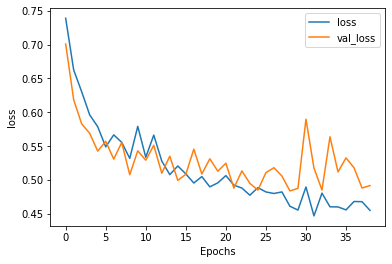

In [189]:
plot_graphs(history1, "loss")



# **LSTM**

**Text Preprocessing**

In [ ]:
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

In [ ]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
from tqdm import tqdm
preprocessed_text = []
# tqdm is for printing the status bar
for sentance in tqdm(train_df['Description'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_text.append(sentance.strip())

 46%|████▌     | 3284/7201 [00:00<00:00, 4729.18it/s]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 7201/7201 [00:01<00:00, 4695.65it/s]


In [ ]:
train_df['Description']=preprocessed_text

In [ ]:
train_df

,Description,Commenting,Staring,Touching
0,walking along crowded street holding mums hand...,0,0,1
1,incident took place evening metro two guys sta...,0,1,0
2,waiting bus man came bike offering liftvto you...,1,0,0
3,incident happened inside train,0,0,0
4,witnessed incident chain brutally snatched eld...,0,0,0
...,...,...,...,...
7196,person near construction site probably laborer...,0,1,0
7197,threatened making inappropriate conversation t...,1,0,0
7198,happened morning university metro station guys...,1,0,0
7199,one day aunt returniec frm office shaunt e fou...,0,0,0


In [ ]:
preprocessed_text = []
# tqdm is for printing the status bar
for sentance in tqdm(dev_df['Description'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_text.append(sentance.strip())

100%|██████████| 990/990 [00:00<00:00, 4327.37it/s]


In [ ]:
dev_df['Description']=preprocessed_text


In [ ]:
dev_df

,Description,Commenting,Staring,Touching
0,buses approaching place highly unsafe,1,0,1
1,man commenting,1,0,0
2,share auto,0,0,1
3,coming club night friends guys came stopped us...,1,0,0
4,one friends molested crowd happened no bridge ...,0,0,1
...,...,...,...,...
985,returning home riding bicycle almost near home...,1,0,0
986,two boys bike commented abused friend leaving ...,1,0,0
987,evening guy showed middle finger called slut l...,1,0,0
988,evening time two young boys riding bike roamin...,0,0,0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

vocab_size = 10000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['Description'])
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'a': 6,
 'and': 2,
 'i': 4,
 'in': 8,
 'me': 10,
 'my': 9,
 'the': 3,
 'to': 7,
 'was': 5}

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_df['Description'])
print(train_sequences[10])

[202, 2, 81, 59, 18, 77, 11, 3, 4361, 337, 3, 374, 157, 13, 3, 2521, 1670, 425, 10, 2, 9, 35, 225, 17, 40, 3105, 22, 3, 3106, 2, 692, 4362, 13, 3, 1670, 349, 295, 189, 57, 214]


In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(train_padded[10])

print(len(train_sequences))
print(train_padded.shape)

[ 202    2   81   59   18   77   11    3 4361  337    3  374  157   13
    3 2521 1670  425   10    2    9   35  225   17   40 3105   22    3
 3106    2  692 4362   13    3 1670  349  295  189   57  214    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(dev_df['Description'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

990
(990, 200)


In [ ]:

training_label_seq = train_df['Commenting']
validation_label_seq = dev_df['Commenting']



In [ ]:
  from tensorflow.keras.layers import Embedding,LSTM,Dense,GlobalAvgPool1D,Flatten,Bidirectional,Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.regularizers import L2,L1


In [ ]:
model = tf.keras.Sequential([
    Embedding(input_dim=vocab_size,input_length=200, output_dim=128),
    Bidirectional( LSTM(128,recurrent_dropout=0.8,return_sequences=True,)),
    Bidirectional( LSTM(64,recurrent_dropout=0.8,return_sequences=True,)),
    #LSTM(32),
    Flatten(),
    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=L2(0.0001),kernel_initializer='glorot_uniform'),
    Dropout(0.8),

    #tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=L2(0.0001),kernel_initializer='glorot_uniform'),
        #Dropout(0.5),

    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=L2(0.0001),kernel_initializer='glorot_uniform'),

    #Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid',kernel_regularizer=L2(0.0001),kernel_initializer='glorot_uniform')
])
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 200, 128)          1280000   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 200, 256)          263168    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 200, 128)          164352    
_________________________________________________________________
flatten_44 (Flatten)         (None, 25600)             0         
_________________________________________________________________
dense_123 (Dense)            (None, 512)               13107712  
_________________________________________________________________
dropout_37 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_124 (Dense)            (None, 64)              

In [ ]:
num_words = len(tokenizer.word_index) + 1
num_words

8206

In [ ]:
train_padded.shape
print(type(training_label_seq))

<class 'pandas.core.series.Series'>


In [ ]:
train_padded=  train_padded.reshape(7201 ,200)
validation_padded=validation_padded.reshape(1701,200)


In [ ]:
my_callbacks1 = [
    tf.keras.callbacks.EarlyStopping(patience=5)
]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq),batch_size=16,callbacks=my_callbacks1, steps_per_epoch=20,
                    validation_steps=10)

Epoch 1/100
20/20 [==============================] - 57s 2s/step - loss: 0.8295 - accuracy: 0.5718 - val_loss: 0.7953 - val_accuracy: 0.6500
Epoch 2/100
20/20 [==============================] - 48s 2s/step - loss: 0.8271 - accuracy: 0.5889 - val_loss: 0.8535 - val_accuracy: 0.3500
Epoch 3/100
20/20 [==============================] - 48s 2s/step - loss: 0.9015 - accuracy: 0.5648 - val_loss: 0.8002 - val_accuracy: 0.6500
Epoch 4/100
20/20 [==============================] - 49s 2s/step - loss: 0.8002 - accuracy: 0.6236 - val_loss: 0.8576 - val_accuracy: 0.3938
Epoch 5/100
20/20 [==============================] - 49s 2s/step - loss: 0.8041 - accuracy: 0.6396 - val_loss: 0.7500 - val_accuracy: 0.6938
Epoch 6/100
20/20 [==============================] - 48s 2s/step - loss: 0.7331 - accuracy: 0.7139 - val_loss: 0.8181 - val_accuracy: 0.5813
Epoch 7/100
20/20 [==============================] - 49s 2s/step - loss: 0.7912 - accuracy: 0.6798 - val_loss: 0.7783 - val_accuracy: 0.6750
Epoch 8/100
2

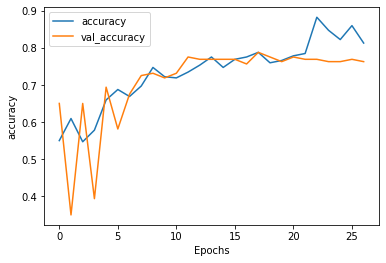

In [ ]:
plot_graphs(history, "accuracy")

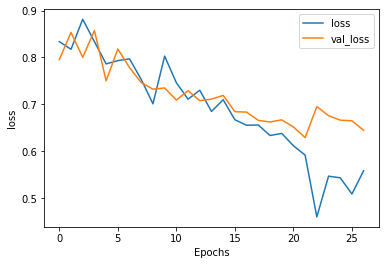

In [ ]:
plot_graphs(history, "loss")

# Preparing Test Data to evaluate

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_df['Description'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(test_sequences))
print(test_padded.shape)

1701
(1701, 200)


In [ ]:
test_label_seq = test_df['Commenting']


In [ ]:
model.evaluate(test_padded,test_label_seq)

54/54 [==============================] - 11s 195ms/step - loss: 0.5764 - accuracy: 0.8001


[0.576447606086731, 0.800117552280426]